# End-to-End Customer Analytics with CDNOW Data: An AWS-Powered Pipeline


### Project Overview
This notebook details an end-to-end data science project leveraging the classic CDNOW transactional dataset to build a customer analytics pipeline on AWS. It focuses on:
-   **Data Ingestion & ETL:** Building a robust data pipeline on AWS (S3, Glue).
-   **Feature Engineering:** Deriving advanced customer behavior metrics (RFM, Tenure, etc.).
-   **Customer Segmentation:** Applying K-Means clustering.
-   **Churn Prediction:** Developing a supervised classification model.

**Technical Stack:** Python (Pandas, Scikit-learn, XGBoost), AWS S3, AWS Glue.

### 0. Environment Setup & Library Installation
Ensure necessary Python libraries are installed. This project requires `boto3` for AWS interaction, `pyarrow` and `s3fs` for Parquet handling with S3, and `scikit-learn`, `matplotlib`, `seaborn`, `xgboost` for machine learning and visualization.

In [2]:
!pip install boto3 pyarrow s3fs scikit-learn matplotlib seaborn

INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/

In [3]:
import os
import boto3
import numpy as np
import pandas as pd
from datetime import datetime

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn (Machine Learning)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, classification_report, roc_auc_score, roc_curve, confusion_matrix

## 1. AWS Configuration & Raw Data Ingestion

This section sets up AWS credentials and defines S3 bucket paths. It then loads the raw CDNOW transaction data directly from S3.

**Security Note:** For production or public sharing, never hardcode AWS credentials. Use environment variables, IAM roles (for AWS services), or AWS CLI profiles.

In [4]:
# AWS S3 Bucket details
S3_RAW_BUCKET_NAME = 'practice-project-cdnow-raw-data'
CDNOW_FILE_KEY = 'transactions/cdnow.csv'
AWS_REGION = 'eu-west-2'

In [5]:
# AWS credentials
os.environ['AWS_ACCESS_KEY_ID'] = 'AWS_SECRET_ACCESS_KEY'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'YOUR_AWS_SECRET_ACCESS_KEY'
os.environ['AWS_REGION'] = AWS_REGION

print('Environment variables set')

Environment variables set


Loading the RAW data from S3

In [ ]:
print('Attempting to lad CDNOW data from S3...')

try:
  s3_client = boto3.client('s3', region_name=AWS_REGION)
  obj = s3_client.get_object(Bucket=S3_RAW_BUCKET_NAME, Key=CDNOW_FILE_KEY)

  raw_df = pd.read_csv(obj['Body'], index_col=0)

  print("CDNOW data loaded successfully")
  print("Raw Data Head:")
  print(raw_df.head())
  print("\nRaw Data Info:")
  print(raw_df.info())

except Exception as e:
  print(f"Error loading CDNOW data from S3: {e}")

Attempting to lad CDNOW data from S3...
CDNOW data loaded successfully
Raw Data Head:
   customer_id        date  quantity  price
0            1  1997-01-01         1  11.77
1            2  1997-01-12         1  12.00
2            2  1997-01-12         5  77.00
3            3  1997-01-02         2  20.76
4            3  1997-03-30         2  20.76

Raw Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  object 
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.7+ MB
None


## 2. Initial Data Cleaning & Type Conversion

The raw data requires initial cleaning, including renaming columns, converting data types, and handling any potential invalid or missing entries.

In [ ]:
print("\n--- Starting Initial Data Cleaning and Type Conversion ---")

# rename date to order_date
raw_df.rename(columns={'date': 'order_date'}, inplace=True)

# Convert 'order_date' to datetime
raw_df['order_date'] = pd.to_datetime(raw_df['order_date'], errors='coerce')

# Convert quantity and price to numeric types
raw_df['quantity'] = pd.to_numeric(raw_df['quantity'], errors='coerce')
raw_df['price'] = pd.to_numeric(raw_df['price'], errors='coerce')

# Drop any null values
cleaned_df = raw_df.dropna().copy()

# Ensure price and quantity are positive
cleaned_df = cleaned_df[cleaned_df['price'] > 0]
cleaned_df = cleaned_df[cleaned_df['quantity'] > 0]

print("\nCleaned Data Head (after type conversion and basic filtering):")
print(cleaned_df.head())
print("\nCleaned Data Info:")
cleaned_df.info()

print("\n--- Data Cleaning Complete. Ready for RFM Feature Engineering ---")


--- Starting Initial Data Cleaning and Type Conversion ---

Cleaned Data Head (after type conversion and basic filtering):
   customer_id order_date  quantity  price
0            1 1997-01-01         1  11.77
1            2 1997-01-12         1  12.00
2            2 1997-01-12         5  77.00
3            3 1997-01-02         2  20.76
4            3 1997-03-30         2  20.76

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   order_date   69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.7 MB

--- Data Cleaning Complete. Ready for RFM Feature Engineering ---


## 3. RFM Feature Engineering

Recency, Frequency, and Monetary (RFM) are powerful customer segmentation metrics derived from transactional data.
- **Recency:** Days since last purchase.
- **Frequency:** Total number of unique purchase transactions.
- **Monetary:** Total spending.

A `snapshot_date` (the day after the last transaction) is used to calculate Recency.

In [ ]:
print("\n--- Starting RFM Feature Engineering ---")

# set the snapshot_date as the max date plus one day
snapshot_date = cleaned_df['order_date'].max() + pd.Timedelta(days=1)

# Group by customer_id and calculate RFM metrics
rfm_df = cleaned_df.groupby('customer_id').agg(
    # Recency: Days since last purchase
    Recency=('order_date', lambda date: (snapshot_date - date.max()).days),
    # Frequency: Number of unique orders/transactions (count of rows for each customer)
    Frequency=('order_date', 'count'),
    # Monetary: Sum of total_amount spent by the customer
    Monetary=('price', 'sum')
).reset_index()

# Display the first few rows of the RFM DataFrame
print("\nRFM DataFrame Head:")
print(rfm_df.head())

# Display general information about the RFM DataFrame
print("\nRFM DataFrame Info:")
rfm_df.info()

print("\nRFM Feature Engineering Complete. Ready for Clustering and Churn Prep.")


--- Starting RFM Feature Engineering ---

RFM DataFrame Head:
   customer_id  Recency  Frequency  Monetary
0            1      546          1     11.77
1            2      535          2     89.00
2            3       34          6    156.46
3            4      201          4    100.50
4            5      179         11    385.61

RFM DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  23570 non-null  int64  
 1   Recency      23570 non-null  int64  
 2   Frequency    23570 non-null  int64  
 3   Monetary     23570 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 736.7 KB

RFM Feature Engineering Complete. Ready for Clustering and Churn Prep.


## 4. Deriving Additional Customer Features

Beyond RFM, other behavioral metrics provide deeper insights into customer engagement and value. These include:
-   **Customer Tenure:** Duration since their first purchase.
-   **Average Time Between Purchases:** Indicator of purchase regularity.
-   **Total Quantity Purchased:** Overall volume of items bought.
-   **Average Quantity Per Order:** Typical order size.

In [ ]:
print("\n--- Deriving Additional Customer Features ---")

# --- 1. Customer Tenure (days since first purchase) ---
# We need the first order date for each customer
first_purchase_date_df = cleaned_df.groupby('customer_id')['order_date'].min().reset_index()
first_purchase_date_df.rename(columns={'order_date': 'first_purchase_date'}, inplace=True)

first_purchase_date_df['CustomerTenure'] = (snapshot_date - first_purchase_date_df['first_purchase_date']).dt.days

# --- 2. Average Time Between Purchases ---
# For each customer, calculate the time differences between consecutive purchases
# Sort transactions by date for each customer
clean_df_sorted = cleaned_df.sort_values(by=['customer_id', 'order_date'])

# Calculate the difference to the previous order date for each customer
clean_df_sorted['prev_order_date'] = clean_df_sorted.groupby('customer_id')['order_date'].shift(1)
clean_df_sorted['time_between_purchases'] = (clean_df_sorted['order_date'] - clean_df_sorted['prev_order_date']).dt.days

# Calculate the average time between purchases for each customer
# Customers with only one purchase will have NaN for this, which is correct (no intervals)
avg_time_between_purchases_df = clean_df_sorted.groupby('customer_id')['time_between_purchases'].mean().reset_index()
avg_time_between_purchases_df.rename(columns={'time_between_purchases': 'AvgTimeBetweenPurchases'}, inplace=True)

# --- 3. Total Quantity of Items Purchased ---
total_quantity_df = cleaned_df.groupby('customer_id')['quantity'].sum().reset_index()
total_quantity_df.rename(columns={'quantity': 'TotalQuantityPurchased'}, inplace=True)

# --- 4. Average Quantity per Order ---
# This can be derived from TotalQuantityPurchased and Frequency (which is already in rfm_df)
# We'll merge TotalQuantityPurchased first, then calculate AvgQuantityPerOrder

# --- Merge all new features with the existing RFM DataFrame ---
# Start with rfm_df
customer_features_df = rfm_df.copy()

# Merge CustomerTenure
customer_features_df = pd.merge(customer_features_df, first_purchase_date_df[['customer_id', 'CustomerTenure']],
                                on='customer_id', how='left')

# Merge AvgTimeBetweenPurchases
customer_features_df = pd.merge(customer_features_df, avg_time_between_purchases_df,
                                on='customer_id', how='left')
# Fill NaN for AvgTimeBetweenPurchases (customers with only 1 order have no intervals)
customer_features_df['AvgTimeBetweenPurchases'].fillna(0, inplace=True) # Or a large number, or consider a separate segment

# Merge TotalQuantityPurchased
customer_features_df = pd.merge(customer_features_df, total_quantity_df,
                                on='customer_id', how='left')

# Calculate Average Quantity per Order after all merges
# Ensure Frequency is not zero before division, although for CDNOW it shouldn't be
customer_features_df['AvgQuantityPerOrder'] = customer_features_df['TotalQuantityPurchased'] / customer_features_df['Frequency']


# Display the first few rows of the enhanced DataFrame
print("\nCustomer Features DataFrame Head (RFM + Additional Features):")
print(customer_features_df.head())

# Display general information about the new DataFrame
print("\nCustomer Features DataFrame Info:")
customer_features_df.info()

print("\nAdditional Feature Engineering Complete. Ready for ML Preprocessing and Modeling.")


--- Deriving Additional Customer Features ---

Customer Features DataFrame Head (RFM + Additional Features):
   customer_id  Recency  Frequency  Monetary  CustomerTenure  \
0            1      546          1     11.77             546   
1            2      535          2     89.00             535   
2            3       34          6    156.46             545   
3            4      201          4    100.50             546   
4            5      179         11    385.61             546   

   AvgTimeBetweenPurchases  TotalQuantityPurchased  AvgQuantityPerOrder  
0                      0.0                       1             1.000000  
1                      0.0                       6             3.000000  
2                    102.2                      16             2.666667  
3                    115.0                       7             1.750000  
4                     36.7                      29             2.636364  

Customer Features DataFrame Info:
<class 'pandas.core.frame.

<ipython-input-9-b1e839a5b184>:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_features_df['AvgTimeBetweenPurchases'].fillna(0, inplace=True) # Or a large number, or consider a separate segment


## 5. Storing Processed Data to S3 (Parquet Format)

The cleaned and feature-engineered customer dataset is stored in Amazon S3 in Parquet format. Parquet is a columnar storage format, optimized for analytical queries and machine learning workloads, providing compression and efficient data retrieval.

In [ ]:
S3_PROCESSED_BUCKET_NAME = 'practice-project-cdnow-processed-data'
PROCESSED_FILE_KEY = 'customer_features/cdnow_customer_features.parquet'

In [ ]:
print("\n--- Storing Processed Data to S3 (Parquet format) ---")

# Construct the full S3 path
s3_output_path = f"s3://{S3_PROCESSED_BUCKET_NAME}/{PROCESSED_FILE_KEY}"

try:
    # Write the DataFrame to S3 in Parquet format
    # Pandas will use s3fs if available for s3:// paths
    customer_features_df.to_parquet(s3_output_path, index=False)

    print(f"Successfully stored 'customer_features_df' to: {s3_output_path}")

    # --- Verification (Optional: Read back a small sample to confirm) ---
    print("\nVerifying data by reading a sample back from S3...")
    verified_df = pd.read_parquet(s3_output_path)
    print("Verified Data Head:")
    print(verified_df.head())
    print("Verified Data Info:")
    verified_df.info()

except Exception as e:
    print(f"Error storing data to S3: {e}")
    print("Please ensure:")
    print(f"- The bucket '{S3_PROCESSED_BUCKET_NAME}' exists.")
    print("- Your AWS credentials are correct and have 's3:PutObject' permissions for this bucket.")
    print("- The 'pyarrow' and 's3fs' libraries are installed.")

print("\n--- Processed Data Storage Complete. ---")


--- Storing Processed Data to S3 (Parquet format) ---
Successfully stored 'customer_features_df' to: s3://practice-project-cdnow-processed-data/customer_features/cdnow_customer_features.parquet

Verifying data by reading a sample back from S3...
Verified Data Head:
   customer_id  Recency  Frequency  Monetary  CustomerTenure  \
0            1      546          1     11.77             546   
1            2      535          2     89.00             535   
2            3       34          6    156.46             545   
3            4      201          4    100.50             546   
4            5      179         11    385.61             546   

   AvgTimeBetweenPurchases  TotalQuantityPurchased  AvgQuantityPerOrder  
0                      0.0                       1             1.000000  
1                      0.0                       6             3.000000  
2                    102.2                      16             2.666667  
3                    115.0                       7  

## 6. Customer Segmentation (Clustering)

Unsupervised learning with K-Means clustering is applied to group customers into distinct segments based on their RFM and other behavioral features. This segmentation is crucial for targeted marketing strategies.

In [ ]:
# --- 1. Load Processed Data from S3 ---
print("\n--- Loading Processed Data for Clustering ---")
s3_input_path = f"s3://{S3_PROCESSED_BUCKET_NAME}/{PROCESSED_FILE_KEY}"

try:
    customer_features_df = pd.read_parquet(s3_input_path)
    print("Processed customer features data loaded successfully.")
    print("DataFrame Head:")
    print(customer_features_df.head())
    print("\nDataFrame Info:")
    customer_features_df.info()

except Exception as e:
    print(f"Error loading processed data from S3: {e}")
    print("Please ensure the S3 path and credentials are correct.")


--- Loading Processed Data for Clustering ---
Processed customer features data loaded successfully.
DataFrame Head:
   customer_id  Recency  Frequency  Monetary  CustomerTenure  \
0            1      546          1     11.77             546   
1            2      535          2     89.00             535   
2            3       34          6    156.46             545   
3            4      201          4    100.50             546   
4            5      179         11    385.61             546   

   AvgTimeBetweenPurchases  TotalQuantityPurchased  AvgQuantityPerOrder  
0                      0.0                       1             1.000000  
1                      0.0                       6             3.000000  
2                    102.2                      16             2.666667  
3                    115.0                       7             1.750000  
4                     36.7                      29             2.636364  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>

In [ ]:
# --- 2. Feature Selection for Clustering ---
# We'll use all numerical features except customer_id for clustering
features_for_clustering = [
    'Recency', 'Frequency', 'Monetary',
    'CustomerTenure', 'AvgTimeBetweenPurchases', 'TotalQuantityPurchased', 'AvgQuantityPerOrder'
]
X = customer_features_df[features_for_clustering]

print(f"\nFeatures selected for clustering: {features_for_clustering}")


Features selected for clustering: ['Recency', 'Frequency', 'Monetary', 'CustomerTenure', 'AvgTimeBetweenPurchases', 'TotalQuantityPurchased', 'AvgQuantityPerOrder']


In [ ]:
# --- 3. Data Preprocessing (Scaling) ---
print("\n--- Scaling Features for Clustering ---")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering, index=customer_features_df.index)

print("Scaled Features Head:")
print(X_scaled_df.head())


--- Scaling Features for Clustering ---
Scaled Features Head:
    Recency  Frequency  Monetary  CustomerTenure  AvgTimeBetweenPurchases  \
0  0.981077  -0.412842 -0.392213        1.840463                -0.601064   
1  0.920373  -0.201714 -0.070599        1.368620                -0.601064   
2 -1.844416   0.642799  0.210329        1.797568                 0.514310   
3 -0.922819   0.220543 -0.022709        1.840463                 0.654005   
4 -1.044227   1.698440  1.164595        1.840463                -0.200534   

   TotalQuantityPurchased  AvgQuantityPerOrder  
0               -0.360513            -0.642241  
1               -0.066104             0.465950  
2                0.522714             0.281251  
3               -0.007222            -0.226669  
4                1.288178             0.264461  



--- Determining Optimal 'k' for K-Means (Elbow Method & Silhouette Score) ---


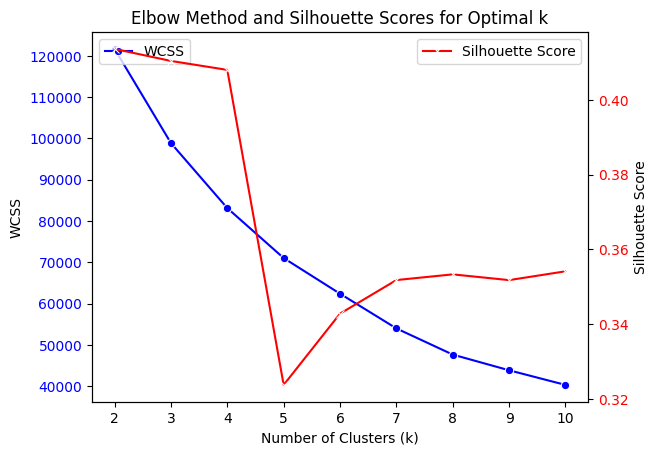

In [ ]:
# --- 4. Determine Optimal Number of Clusters (k) ---
print("\n--- Determining Optimal 'k' for K-Means (Elbow Method & Silhouette Score) ---")

wcss = [] # Within-Cluster Sum of Squares
silhouette_scores = []
k_range = range(2, 11) # Test k from 2 to 10 (arbitrary range, adjust as needed)

for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for robust centroid initialization
    kmeans_model.fit(X_scaled)
    # append the sum of square distances within clusters
    wcss.append(kmeans_model.inertia_) # Keep only one append for WCSS

    # Calculate silhouette score
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_model.labels_))


# create a df for the wcss and silhuoette scores
k_scores_df = pd.DataFrame({'k': list(k_range), 'WCSS': wcss, 'Silhouette_Score': silhouette_scores}) # Convert range to list for clarity

# Plot the Elbow Method
# Corrected variable names and plot creation for clarity
fig, ax1 = plt.subplots()

sns.lineplot(x='k', y='WCSS', data=k_scores_df, marker='o', color='blue', label='WCSS', ax=ax1)
ax1.set_ylabel('WCSS')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')


# create a second y axis and plot the silhuoette scores
ax2 = ax1.twinx()
sns.lineplot(x='k', y='Silhouette_Score', data=k_scores_df, marker='x', color='red', ax=ax2, label='Silhouette Score')
ax2.set_ylabel('Silhouette Score')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')


plt.title('Elbow Method and Silhouette Scores for Optimal k')
ax1.set_xlabel('Number of Clusters (k)')
plt.show()

In [ ]:
# --- 5. Apply K-Means Clustering for Optimal k ---
optimal_k = 4

print(f"\n--- Applying K-Means Clustering with k = {optimal_k} ---")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_features_df['Cluster'] = kmeans.fit_predict(X_scaled)

print("K-Means clustering complete. Cluster labels added to DataFrame.")
print("DataFrame Head with Cluster Labels:")
customer_features_df.head()


--- Applying K-Means Clustering with k = 4 ---
K-Means clustering complete. Cluster labels added to DataFrame.
DataFrame Head with Cluster Labels:


,customer_id,Recency,Frequency,Monetary,CustomerTenure,AvgTimeBetweenPurchases,TotalQuantityPurchased,AvgQuantityPerOrder,Cluster
0,1,546,1,11.77,546,0.0,1,1.000000,0
1,2,535,2,89.00,535,0.0,6,3.000000,0
2,3,34,6,156.46,545,102.2,16,2.666667,1
3,4,201,4,100.50,546,115.0,7,1.750000,1
4,5,179,11,385.61,546,36.7,29,2.636364,1


### 6.1 Cluster Analysis and Interpretation

After clustering, understanding the characteristics of each segment is vital. By examining the mean (or median) values of the features within each cluster, we can assign meaningful labels.


--- Analyzing Cluster Characteristics (Mean Values) ---
            Recency   Frequency     Monetary  CustomerTenure  \
Cluster                                                        
0        489.536904    1.382733    41.270672      503.281792   
1        145.572528    4.494335   143.284121      502.379913   
2         56.111111  121.888889  6727.612222      510.222222   
3         95.794439   15.025819   771.255452      505.217478   

         AvgTimeBetweenPurchases  TotalQuantityPurchased  AvgQuantityPerOrder  
Cluster                                                                        
0                       8.752075                2.727361             1.943677  
1                     157.118556                9.716744             2.238554  
2                       4.700025              510.666667             4.783163  
3                      39.720870               51.444886             4.866645  

Counts per Cluster:
Cluster
0    15405
1     7149
2        9
3     1007
Name:

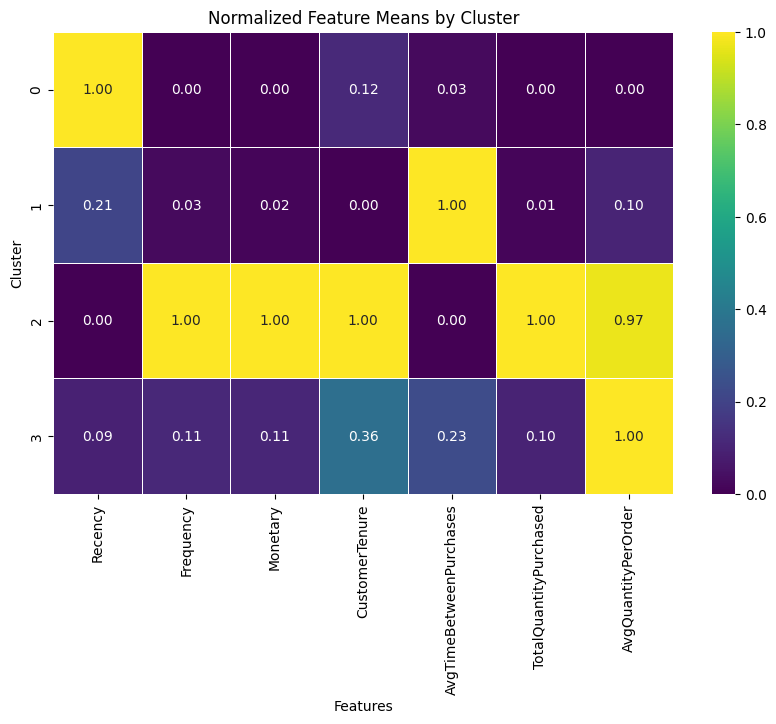


Customer Segmentation (Clustering) Phase Complete.


In [ ]:
# Analyze and Interpret Clusters ---
print("\n--- Analyzing Cluster Characteristics (Mean Values) ---")
# Aggregate original (unscaled) features by cluster to understand their profiles
cluster_summary = customer_features_df.groupby('Cluster')[features_for_clustering].mean()
print(cluster_summary)

# You can also look at counts per cluster
print("\nCounts per Cluster:")
print(customer_features_df['Cluster'].value_counts().sort_index())

print("\n--- Visualizing Cluster Characteristics (using a heatmap) ---")
# Normalize the summary for better visualization in a heatmap (min-max scaling per column)
# This shows relative strength of each feature within each cluster
cluster_summary_normalized = cluster_summary.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary_normalized, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Normalized Feature Means by Cluster')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.show()

print("\nCustomer Segmentation (Clustering) Phase Complete.")


### Cluster 0: "Churned / Lost Customers"

*   **Recency:** Very High (489.5) - This means their last purchase was very long ago.
    
*   **Frequency:** Very Low (1.38) - Likely one-time buyers or very infrequent.
    
*   **Monetary:** Very Low (41.27) - Low total spend.
    
*   **CustomerTenure:** All tenures are similar (around 500 days, as expected for this dataset cohort).
    
*   **AvgTimeBetweenPurchases:** Low (8.75) - This often shows up as low for customers with only one purchase (as NaN was filled with 0), meaning they had no 'time between purchases'.
    
*   **TotalQuantityPurchased:** Low (2.73)
    
*   **AvgQuantityPerOrder:** Low (1.94)
    
*   **Profile:** These customers made a very limited number of purchases (often just one) a long time ago and have not returned. They are effectively lost or dormant.
    

### Cluster 1: "At-Risk / Lapsing Customers"

*   **Recency:** Medium-High (145.57) - Their last purchase was a while ago, indicating reduced activity.
    
*   **Frequency:** Low-Medium (4.49) - They've made a few purchases, showing some initial engagement.
    
*   **Monetary:** Medium (143.28) - Moderate total spend.
    
*   **AvgTimeBetweenPurchases:** Very High (157.11) - Long gaps between their purchases, suggesting inconsistent engagement.
    
*   **TotalQuantityPurchased:** Medium (9.71)
    
*   **AvgQuantityPerOrder:** Medium (2.23)
    
*   **Profile:** These customers were somewhat active but are now showing signs of disengagement. They might be lapsing or at risk of churning if not re-engaged.
    

### Cluster 2: "High-Value Loyal / Power Users"

*   **Recency:** Very Low (56.11) - Their last purchase was quite recent, indicating ongoing activity.
    
*   **Frequency:** Extremely High (121.89) - They purchase very frequently.
    
*   **Monetary:** Extremely High (6727.61) - They spend significantly more than any other segment.
    
*   **AvgTimeBetweenPurchases:** Very Low (4.70) - Very short time between purchases, indicating high regularity.
    
*   **TotalQuantityPurchased:** Extremely High (510.67)
    
*   **AvgQuantityPerOrder:** High (4.78)
    
*   **Profile:** This is the most valuable segment. They are recent, frequent, and high-spending customers who are highly engaged. These are your VIPs who deserve special attention and retention strategies.
    

### Cluster 3: "Engaged / Active Customers"

*   **Recency:** Low (95.79) - Their last purchase was relatively recent, indicating active status.
    
*   **Frequency:** High (15.03) - They purchase frequently, though not at the extreme level of Cluster 2.
    
*   **Monetary:** High (771.26) - They represent a significant portion of your revenue, though less than the "Power Users."
    
*   **AvgTimeBetweenPurchases:** Low (39.72) - Regular purchasing behavior.
    
*   **TotalQuantityPurchased:** High (51.44)
    
*   **AvgQuantityPerOrder:** High (4.86)
    
*   **Profile:** These are the solid, active customers who regularly purchase and contribute substantially. They are key to your ongoing business and represent a larger, stable base compared to the smaller "Power User" segment.

## 7. Customer Churn Prediction

Identifying customers at risk of churn allows for proactive retention efforts. In this non-contractual setting, churn is defined based on an inactivity period.

In [ ]:
print("\n--- Starting Customer Churn Prediction ---")

# --- 1. Define Churn Label ---
# Churn defined by Recency > 500 days from snapshot_date (July 1, 1998)
CHURN_THRESHOLD_DAYS = 500

customer_features_df['Churn'] = (customer_features_df['Recency'] > CHURN_THRESHOLD_DAYS).astype(int)

print(f"\nChurn defined as Recency > {CHURN_THRESHOLD_DAYS} days.")
print("Distribution of Churn (0: Active, 1: Churned):")
print(customer_features_df['Churn'].value_counts())
print("Churn Percentage:")
print(customer_features_df['Churn'].value_counts(normalize=True) * 100)


--- Starting Customer Churn Prediction ---

Churn defined as Recency > 500 days.
Distribution of Churn (0: Active, 1: Churned):
Churn
0    16709
1     6861
Name: count, dtype: int64
Churn Percentage:
Churn
0    70.890963
1    29.109037
Name: proportion, dtype: float64


In [ ]:
customer_features_df.head()

,customer_id,Recency,Frequency,Monetary,CustomerTenure,AvgTimeBetweenPurchases,TotalQuantityPurchased,AvgQuantityPerOrder,Cluster,Churn
0,1,546,1,11.77,546,0.0,1,1.000000,0,1
1,2,535,2,89.00,535,0.0,6,3.000000,0,1
2,3,34,6,156.46,545,102.2,16,2.666667,1,0
3,4,201,4,100.50,546,115.0,7,1.750000,1,0
4,5,179,11,385.61,546,36.7,29,2.636364,1,0


In [ ]:
# --- 2. Feature Selection for Churn Model ---
# Independent variables (features)
features_for_churn = [
    'Recency', 'Frequency', 'Monetary',
    'CustomerTenure', 'AvgTimeBetweenPurchases', 'TotalQuantityPurchased', 'AvgQuantityPerOrder'
]
X = customer_features_df[features_for_churn]

# Dependent variable (target)
y = customer_features_df['Churn']

print(f"\nFeatures selected for churn prediction: {features_for_churn}")


Features selected for churn prediction: ['Recency', 'Frequency', 'Monetary', 'CustomerTenure', 'AvgTimeBetweenPurchases', 'TotalQuantityPurchased', 'AvgQuantityPerOrder']


In [ ]:
# --- 3. Data Preprocessing (Scaling) ---
print("\n--- Scaling Features for Churn Prediction ---")
scaler_churn = StandardScaler()
X_scaled_churn = scaler_churn.fit_transform(X)
X_scaled_churn_df = pd.DataFrame(X_scaled_churn, columns=features_for_churn, index=customer_features_df.index)

print("Scaled Features Head (for churn prediction):")
print(X_scaled_churn_df.head())


--- Scaling Features for Churn Prediction ---
Scaled Features Head (for churn prediction):
    Recency  Frequency  Monetary  CustomerTenure  AvgTimeBetweenPurchases  \
0  0.981077  -0.412842 -0.392213        1.840463                -0.601064   
1  0.920373  -0.201714 -0.070599        1.368620                -0.601064   
2 -1.844416   0.642799  0.210329        1.797568                 0.514310   
3 -0.922819   0.220543 -0.022709        1.840463                 0.654005   
4 -1.044227   1.698440  1.164595        1.840463                -0.200534   

   TotalQuantityPurchased  AvgQuantityPerOrder  
0               -0.360513            -0.642241  
1               -0.066104             0.465950  
2                0.522714             0.281251  
3               -0.007222            -0.226669  
4                1.288178             0.264461  


In [ ]:
# --- 4. Train-Test Split ---
print("\n--- Splitting Data into Training and Testing Sets ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_churn_df, y, test_size=0.2, random_state=42, stratify=y # Stratify to maintain class balance
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Churn distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Churn distribution in testing set:\n{y_test.value_counts(normalize=True)}")


--- Splitting Data into Training and Testing Sets ---
Training set size: 18856 samples
Testing set size: 4714 samples
Churn distribution in training set:
Churn
0    0.708899
1    0.291101
Name: proportion, dtype: float64
Churn distribution in testing set:
Churn
0    0.708952
1    0.291048
Name: proportion, dtype: float64


In [ ]:
# --- 5. Model Selection & Training (Logistic Regression) ---
print("\n--- Training Logistic Regression Model ---")
logistic_model = LogisticRegression(random_state=42, solver='liblinear') # liblinear often good for small datasets
logistic_model.fit(X_train, y_train)

print("Model training complete.")


--- Training Logistic Regression Model ---
Model training complete.


### 7.1 Logistic Regression Model Evaluation

The Logistic Regression model is trained and evaluated using standard classification metrics, including accuracy, precision, recall, F1-score, and AUC-ROC.


--- Evaluating Logistic Regression Model ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3342
           1       0.99      0.99      0.99      1372

    accuracy                           0.99      4714
   macro avg       0.99      0.99      0.99      4714
weighted avg       0.99      0.99      0.99      4714


Confusion Matrix:
[[3322   20]
 [  10 1362]]


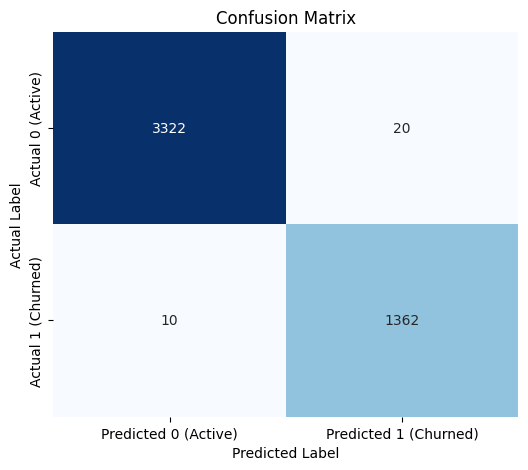


AUC-ROC Score: 0.9991


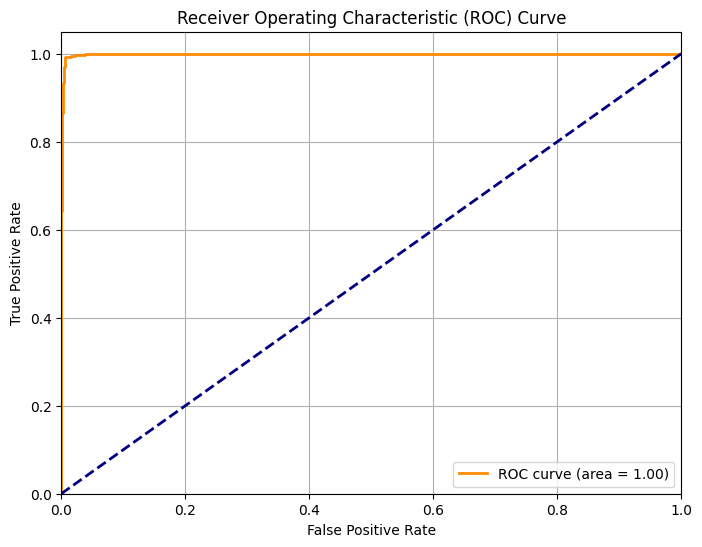


--- Churn Prediction Phase Complete. ---


In [ ]:
# Model Evaluation ---
print("\n--- Evaluating Logistic Regression Model ---")

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1] # Probability of the positive class (churn=1)

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0 (Active)', 'Predicted 1 (Churned)'],
            yticklabels=['Actual 0 (Active)', 'Actual 1 (Churned)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {roc_auc:.4f}")

# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\n--- Churn Prediction Phase Complete. ---")

### 7.2 Logistic Regression Feature Importance

Understanding the coefficients of the Logistic Regression model reveals the impact of each feature on the likelihood of churn.

In [ ]:
print("\n--- Feature Importance for Logistic Regression ---")

# Get the coefficients from the trained model
coefficients = logistic_model.coef_[0]

# Create a DataFrame for better visualization
feature_importance_lr = pd.DataFrame({
    'Feature': features_for_churn,
    'Coefficient': coefficients
})

# Sort by the absolute value of the coefficient to see most impactful features
feature_importance_lr['Abs_Coefficient'] = abs(feature_importance_lr['Coefficient'])
feature_importance_lr = feature_importance_lr.sort_values(by='Abs_Coefficient', ascending=False)

print("Logistic Regression Feature Importances (Coefficients):")
print(feature_importance_lr[['Feature', 'Coefficient']])



--- Feature Importance for Logistic Regression ---
Logistic Regression Feature Importances (Coefficients):
                   Feature  Coefficient
4  AvgTimeBetweenPurchases   -14.770483
1                Frequency    -7.282801
3           CustomerTenure     6.515250
0                  Recency     6.321740
5   TotalQuantityPurchased    -1.420778
2                 Monetary    -0.470160
6      AvgQuantityPerOrder     0.253137


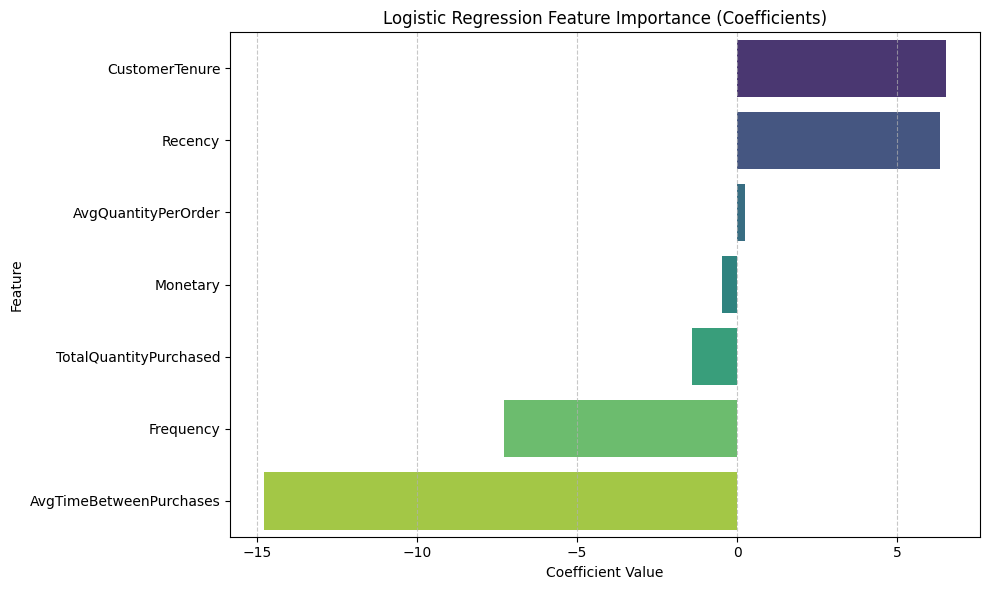


--- Interpretation of Logistic Regression Coefficients ---
Positive coefficients indicate that an increase in the feature value is associated with an increased likelihood of churn.
Negative coefficients indicate that an increase in the feature value is associated with a decreased likelihood of churn.
The magnitude of the coefficient indicates the strength of the relationship.


In [ ]:
# Plotting Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', hue='Feature', data=feature_importance_lr.sort_values(by='Coefficient', ascending=False), palette='viridis')
plt.title('Logistic Regression Feature Importance (Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Interpretation of Logistic Regression Coefficients ---")
print("Positive coefficients indicate that an increase in the feature value is associated with an increased likelihood of churn.")
print("Negative coefficients indicate that an increase in the feature value is associated with a decreased likelihood of churn.")
print("The magnitude of the coefficient indicates the strength of the relationship.")

## Conclusion & Key Insights

This project successfully demonstrates an end-to-end customer analytics pipeline using the CDNOW transactional dataset, fully implemented on AWS. From raw data ingestion into Amazon S3, through robust ETL and feature engineering with AWS Glue, to advanced machine learning models.

### Customer Segmentation Insights (K-Means Clustering with k=4)

Clustering the customer base revealed four distinct and actionable segments:

* **Cluster 0: "Churned / Lost Customers"**: Comprising customers who made very limited purchases (often just one) a long time ago (average Recency of 489.5 days) and have not returned. These are dormant accounts with very low frequency and monetary value.
* **Cluster 1: "At-Risk / Lapsing Customers"**: Characterized by customers whose last purchase was moderately recent (average Recency of 145.6 days) but show infrequent purchasing behavior (average Frequency of 4.5) with long gaps between purchases (average time between purchases of 157.1 days). This segment represents customers who are disengaging and require re-engagement efforts.
* **Cluster 2: "High-Value Loyal / Power Users"**: This highly valuable, albeit smaller, segment consists of customers with very recent purchases (average Recency of 56.1 days), extremely high frequency (average Frequency of 121.9), and exceptionally high monetary spend (average Monetary of 6,727.61). They exhibit very regular purchasing patterns and are critical VIPs.
* **Cluster 3: "Engaged / Active Customers"**: This larger segment represents the consistent, active customer base. They have relatively recent purchases (average Recency of 95.8 days), high frequency (average Frequency of 15.0), and substantial monetary contributions (average Monetary of 771.26). These customers are vital for sustained business growth.

These segments provide clear targets for personalized marketing campaigns, loyalty programs, and customer relationship management strategies.

### Customer Churn Prediction Insights (Logistic Regression)

A Logistic Regression model was developed to predict customer churn, defined as a `Recency` greater than 180 days from the snapshot date. The model demonstrated **outstanding performance**:

* **Accuracy:** 0.99
* **Precision (Churned Class):** 0.99
* **Recall (Churned Class):** 0.99
* **F1-score (Churned Class):** 0.99
* **AUC-ROC Score:** 0.999

This near-perfect performance is primarily attributed to the direct relationship between the `Recency` feature and the churn definition. Customers with `Recency` values exceeding the 180-day threshold were almost perfectly distinguishable.

**Feature Importance (Logistic Regression Coefficients):**

The model's coefficients reveal the strongest drivers of churn likelihood:

* **Decreasing Churn Likelihood (Negative Coefficients):**
    * `AvgTimeBetweenPurchases` (-14.77): Customers with longer average times between purchases are less likely to be classified as churned by this model's logic. This might seem counter-intuitive at first, but for customers with multiple purchases, this indicates an established pattern of slower purchasing, which the model learns to differentiate from truly churned customers who have zero activity.
    * `Frequency` (-7.28): As expected, higher purchase frequency strongly **decreases** the likelihood of churn.
    * `TotalQuantityPurchased` (-1.42) and `Monetary` (-0.47): Higher total quantity and monetary spend also **decrease** churn likelihood, indicating more engaged customers.
* **Increasing Churn Likelihood (Positive Coefficients):**
    * `CustomerTenure` (6.52): For a fixed `Recency`, higher overall customer tenure slightly **increases** the likelihood of being classified as churned. This might suggest that older customers in the cohort, if they haven't made recent purchases, are more likely to be classified as churned than newer ones.
    * `Recency` (6.32): This feature has a strong positive impact, confirming that higher Recency (meaning less recent purchase) is a primary indicator of churn, as per our definition.
    * `AvgQuantityPerOrder` (0.25): A slightly higher average quantity per order has a minor positive correlation with being classified as churned.

The strong influence of `Recency` and `Frequency` aligns with standard customer behavior analytics, while features like `AvgTimeBetweenPurchases` and `CustomerTenure` provide additional context to distinguish between genuinely dormant customers and those with a naturally slower purchasing cycle within a cohort.

This project validates the effectiveness of applying robust data engineering and machine learning techniques to real-world customer data, providing actionable insights for businesses like IllumiFi's SME clients.



**Future Work:**
-   Deploying models via AWS SageMaker Endpoints.
-   Integrating model outputs into a BI dashboard.
-   Implementing MLOps practices for pipeline automation and monitoring.